# Map Fetal cell atlas to pan-fetal immune

Data from Cao et al. 2020

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys,os
import scvi
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import scipy

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
## import utils
cwd = '.'
sys.path.append(cwd)

import map_query_utils

In [6]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [7]:
%load_ext rpy2.ipython


In [8]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)
library(SingleCellExperiment)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

### Download raw counts

From this website https://descartes.brotmanbaty.org/bbi/human-gene-expression-during-development/

Download data for blood cells and 6 organs (3 matched / 3 unmatched with pan-fetal immune organs)

In [8]:
output_dir = '/nfs/team205/ed6/data/Cao2020_FetalCellAtlas/'
keep_organs = [
 'Heart',
 'Liver',
 'Lung',
 'Muscle',
 'Spleen',
 'Thymus']

In [106]:
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

## HSC data    
outfile=output_dir + 'gene_count_blood.RDS'.format(o=org)
link='https://atlas.fredhutch.org/data/bbi/descartes/human_gtex/downloads/data_summarize_fetus_data/gene_count_blood.RDS'.format(o=org)
call = "curl -o {o} {l}".format(o=outfile, l=link)
os.system(call)

## Single organs data
for org in keep_organs:
    outfile=output_dir + '{o}_gene_count.RDS'.format(o=org)
    link='https://atlas.fredhutch.org/data/bbi/descartes/human_gtex/downloads/data_summarize_fetus_data/{o}_gene_count.RDS'.format(o=org)
    call = "curl -o {o} {l}".format(o=outfile, l=link)
    os.system(call)

In [20]:
## Download metadata
var_link = 'https://atlas.fredhutch.org/data/bbi/descartes/human_gtex/downloads/FCA_RNA_supp_files/cells_by_type/df_gene_blood.RDS'
var_outfile = output_dir + var_link.split("/")[-1]
call = "curl -o {o} {l}".format(o=var_outfile, l=var_link)
os.system(call)

obs_link = 'https://atlas.fredhutch.org/data/bbi/descartes/human_gtex/downloads/FCA_RNA_supp_files/cells_by_type/df_cell_blood.RDS'
obs_outfile = output_dir + obs_link.split("/")[-1]
call = "curl -o {o} {l}".format(o=obs_outfile, l=obs_link)
os.system(call)

full_obs_link = 'https://atlas.fredhutch.org/data/bbi/descartes/human_gtex/downloads/data_summarize_fetus_data/df_cell.RDS'
full_obs_outfile = output_dir + full_obs_link.split("/")[-1]
call = "curl -o {o} {l}".format(o=full_obs_outfile, l=full_obs_link)
os.system(call)

full_var_link = 'https://atlas.fredhutch.org/data/bbi/descartes/human_gtex/downloads/data_summarize_fetus_data/df_gene.RDS'
full_var_outfile = output_dir + full_var_link.split("/")[-1]
call = "curl -o {o} {l}".format(o=full_var_outfile, l=full_var_link)
os.system(call)

Convert to `anndata`

In [9]:
%%R -i output_dir -o blood_sce
data <- readRDS(paste0(output_dir, "gene_count_blood.RDS"))
cell_meta_df <- readRDS(paste0(output_dir, "df_cell_blood.RDS"))
gene_meta_df <- readRDS(paste0(output_dir, "df_gene_blood.RDS"))
blood_sce <- SingleCellExperiment(list(counts=data), colData=cell_meta_df, rowData=gene_meta_df)

In [11]:
%%R -i keep_organs -i output_dir
full_cell_meta_df <- readRDS(paste0(output_dir, 'df_cell.RDS'))
full_gene_meta_df <- readRDS(paste0(output_dir, 'df_gene.RDS'))

rownames(full_cell_meta_df) <- full_cell_meta_df$sample
data <- readRDS(paste0(output_dir, keep_organs[1], "_gene_count.RDS"))
data_cell_meta <- full_cell_meta_df[colnames(data),]
data_gene_meta <- full_gene_meta_df[rownames(data),]
organs_sce <- SingleCellExperiment(list(counts=data), colData=data_cell_meta, rowData=data_gene_meta)
for (org in keep_organs[2:length(keep_organs)]){
    data <- readRDS(paste0(output_dir, org, "_gene_count.RDS"))
    data_cell_meta <- full_cell_meta_df[colnames(data),]
    data_gene_meta <- full_gene_meta_df[rownames(data),]
    data_sce <- SingleCellExperiment(list(counts=data), colData=data_cell_meta, rowData=data_gene_meta)
    organs_sce <- cbind(organs_sce, data_sce)
}

In [29]:
%%R -o organs_sce
organs_sce

class: SingleCellExperiment 
dim: 63561 685481 
metadata(0):
assays(1): X
rownames(63561): ENSG00000223972.4 ENSG00000227232.4 ...
  ENSG00000222670.2 ENSG00000251180.2
rowData names(3): gene_id gene_type gene_short_name
colnames(685481): exp4-human-100well.GGCGACTATTGCCGGCAGA
  exp4-human-100well.AGTCGCATTGGCTATGACT ...
  exp3-human-477well.CTATCTCCTAGTCCGCGGA
  exp3-human-478well.GGTCAGTTTACCGCCAACC
colData names(16): sample Exon_reads ... Organ_cell_lineage
  Experiment_batch
reducedDimNames(0):
altExpNames(0):


In [12]:
blood_sce.write_h5ad(output_dir + "gene_count_blood.h5ad")

... storing 'RT_group' as categorical
... storing 'Organ' as categorical
... storing 'Fetus_id' as categorical
... storing 'Sex' as categorical
... storing 'Batch' as categorical
... storing 'Assay' as categorical
... storing 'Experiment_batch' as categorical
... storing 'Blood_cell_name' as categorical
... storing 'SubClusterName' as categorical


In [33]:
for org in keep_organs:
    filename = "/nfs/team205/ed6/data/Cao2020_FetalCellAtlas/{o}_gene_count.h5ad".format(o=org)
    org_adata = organs_sce[organs_sce.obs.Organ == org]
    org_adata.write_h5ad(filename)

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'RT_group' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Organ' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Fetus_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Sex' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Batch' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Main_cluster_name' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Assay' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Organ_cell_lineage' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Experiment_batch' as c

### Prep for scArches

In [38]:
mapping_files = [x for x in os.listdir(output_dir) if ".h5ad" in x]
for f in mapping_files:
    adata = sc.read_h5ad(output_dir + f)
    ## Convert var names to gene IDs
    adata.var_names = [x[0] for x in adata.var["gene_id"].str.split(".")]
    ## Rename batch column
    adata.obs["bbk"] = adata.obs["Batch"]
    ## Save in drive
    adata.write_h5ad("/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/" + f)

In [85]:
## Remove batch column 
mapping_files = [x for x in os.listdir(output_dir) if ".h5ad" in x]
for f in mapping_files:
    adata = sc.read_h5ad("/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/" + f)
    adata.obs.drop(["bbk"], 1, inplace=True)
    adata.write_h5ad("/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/" + f)

Stringent prep (filtering low quality, definition of batch that separates cells from Nuclei)

In [225]:
f = 'gene_count_blood.h5ad'
adata = sc.read_h5ad(output_dir + f)
## Filter cells with sufficient reads
adata = adata[adata.obs["All_reads"] > 500].copy()
## Convert var names to gene IDs
adata.var_names = [x[0] for x in adata.var["gene_id"].str.split(".")]
## Rename batch column
# adata.obs["bbk"] = adata.obs["Batch"].astype("str") + adata.obs["Experiment_batch"].astype("str")
if "bbk" in adata.obs.columns:
    adata.obs.drop(["bbk"], 1, inplace=True)
## Save in drive
adata.write_h5ad("/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/" + f)

### Mapping to PFI with scArches

Running on GPU node:
```
python ./run_map_query.py /home/jupyter/mount/gdrive/Pan_fetal/data4gpu_node/gene_count_blood.h5ad HSC_IMMUNE Cao2020_blood --model_dir scvi_HSC_IMMUNE_model_test/
for o in Thymus Liver Spleen Heart Lung Muscle; do python ./run_map_query.py /home/jupyter/mount/gdrive/Pan_fetal/data4gpu_node/${o}_gene_count.h5ad HSC_IMMUNE Cao2020_${o} --model_dir scvi_HSC_IMMUNE_model_test/; done
```

and then merging with reference and embedding (using fast UMAP)
```
python ./merge_query_2_reference.py /home/jupyter/mount/gdrive/Pan_fetal/data4gpu_node/Thymus_gene_count.mapped2HSC_IMMUNE.h5ad HSC_IMMUNE
```

### Load outputs

In [9]:
data_dir = "/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/"
merged_adata = sc.read_h5ad(data_dir + 'Cao2020_blood.mmapped2HSC_IMMUNE.withReference.h5ad')

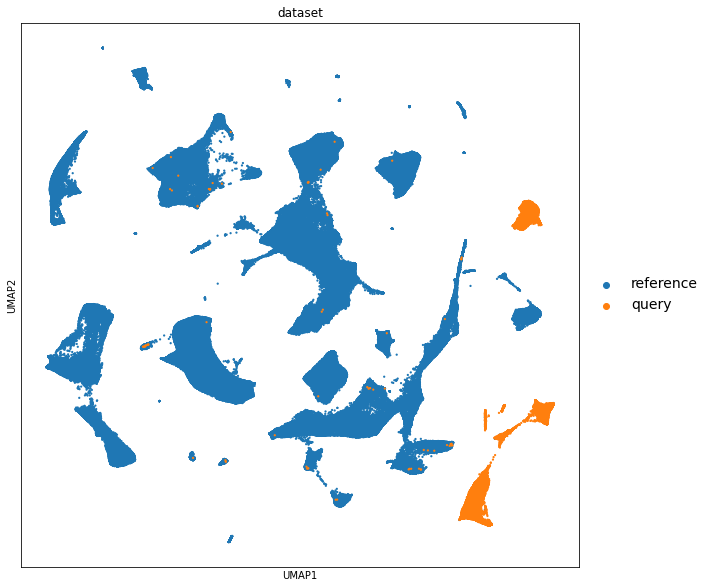

In [11]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(merged_adata, color="dataset", size=20, legend_fontsize= 14)

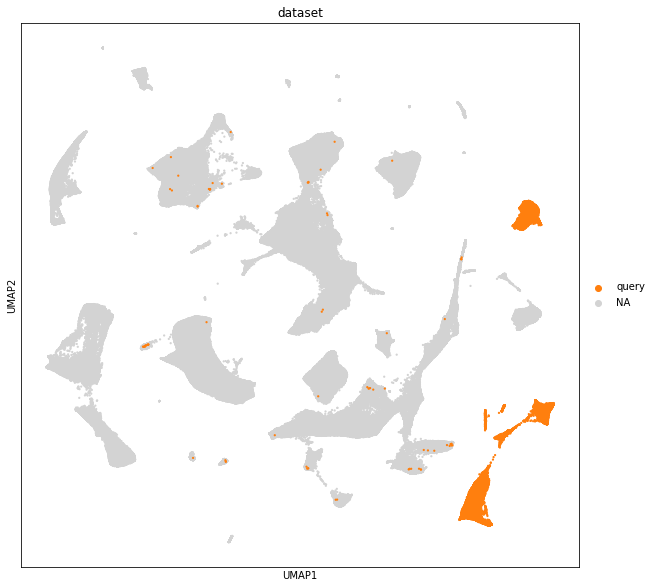

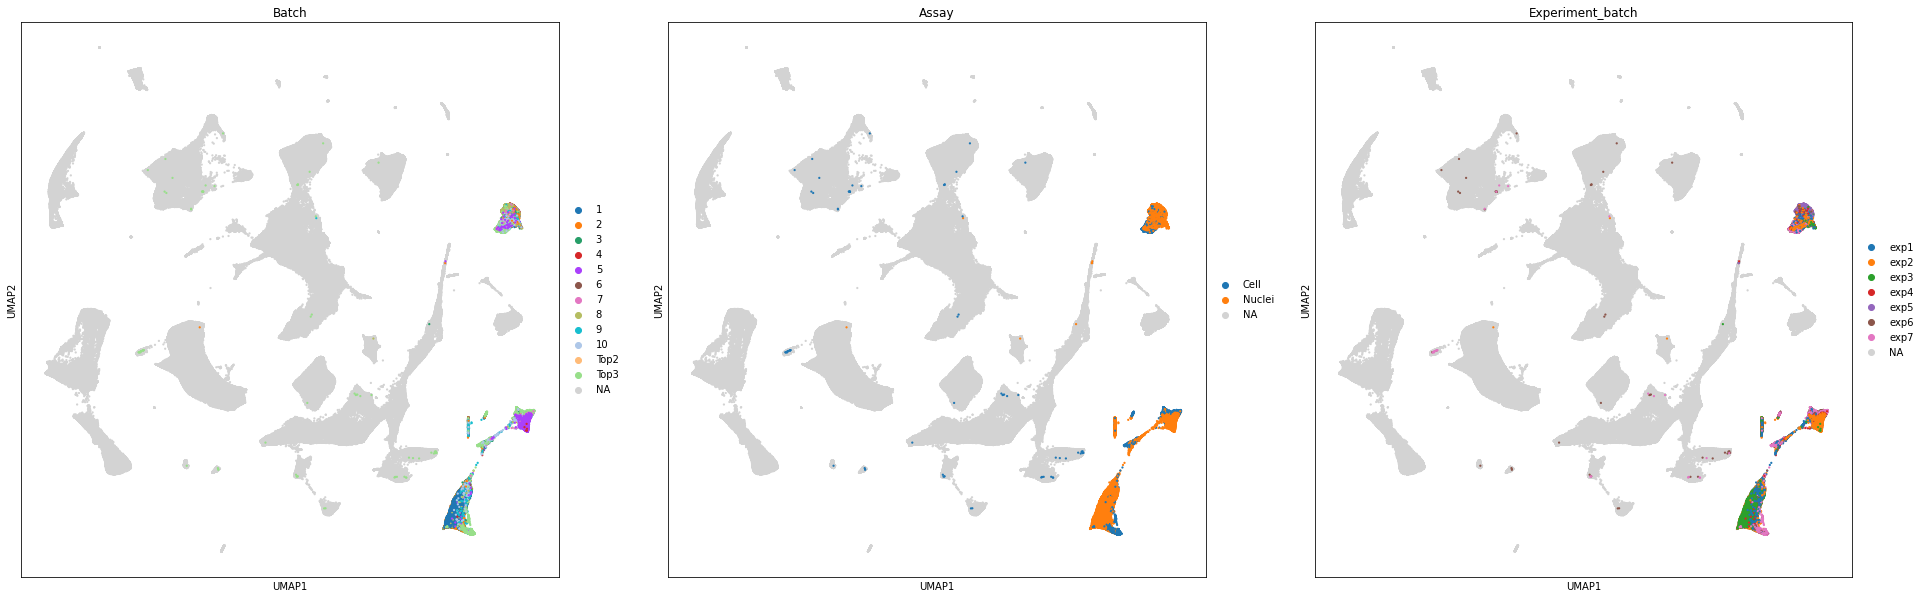

In [43]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(merged_adata, color="dataset", groups=["query"], size=20)
sc.pl.umap(merged_adata, color=["Batch", "Assay", "Experiment_batch"], size=20)

Learnings from today:

- the mapping doesn't work well with single organs: the training looks normal, the definition of batches does not seem to matter
- could it be just lower quality?

In [ ]:
sc.pp.neighbors(merged_adata, use_rep="X_scvi", n_neighbors = 30)
neighbors_normal = merged_adata.obsp.copy()

In [44]:
## Load reference annotations
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)

reference_obs = merged_adata.obs_names[merged_adata.obs.dataset == "reference"]
merged_adata.obs["annotation_reference"] = np.nan
merged_adata.obs.loc[reference_obs, "annotation_reference"] = anno_obs.loc[reference_obs.str.strip("-reference")]["anno_lvl_2_final_clean"].values

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [45]:
map_query_utils.predict_label(merged_adata, anno_col="annotation_reference")

/nfs/team205/ed6/bin/Pan_fetal_immune/src/8_align_query/map_query_utils.py:148: RuntimeWarning: invalid value encountered in true_divide
  new_anno_prob = new_anno.T/n_neighbors_ref


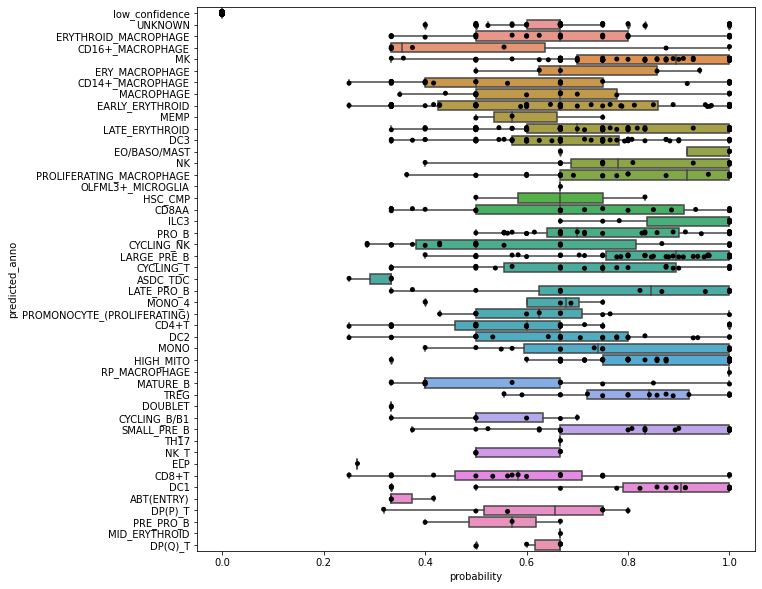

In [46]:
map_query_utils.plot_predicted_anno_probability(merged_adata)

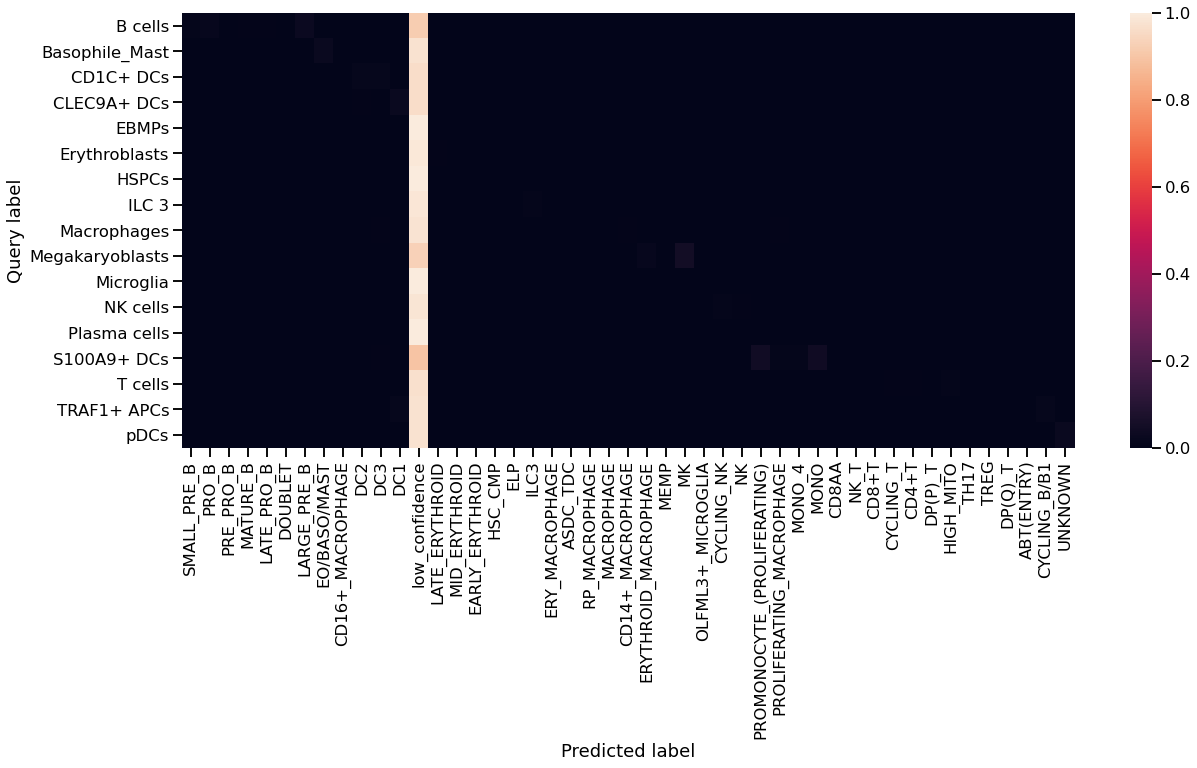

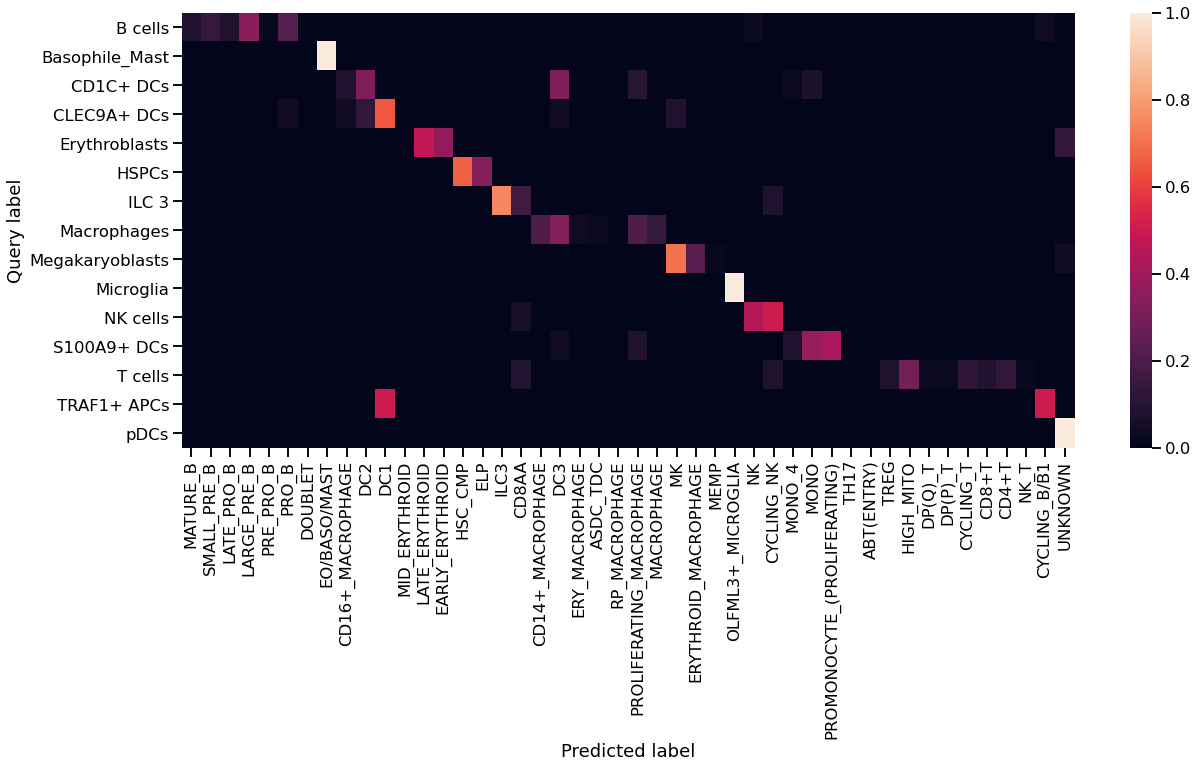

In [52]:
sns.set_context("talk")
query_anno_col='Blood_cell_name'
# query_anno_col='Main_cluster_name'

query_obs = merged_adata.obs_names[merged_adata.obs.dataset == "query"]
empty_query = query_obs[merged_adata[query_obs].obs[query_anno_col].isna()]
merged_adata_clean = merged_adata[~merged_adata.obs_names.isin(empty_query)]

plt.rcParams["figure.figsize"] = [20,8]
map_query_utils.plot_confusion_mat(merged_adata_clean, query_anno_col=query_anno_col, show_low_confidence=True);
plt.show();
map_query_utils.plot_confusion_mat(merged_adata_clean, query_anno_col=query_anno_col, show_low_confidence=False)

... storing 'annotation_reference' as categorical
... storing 'predicted_anno' as categorical


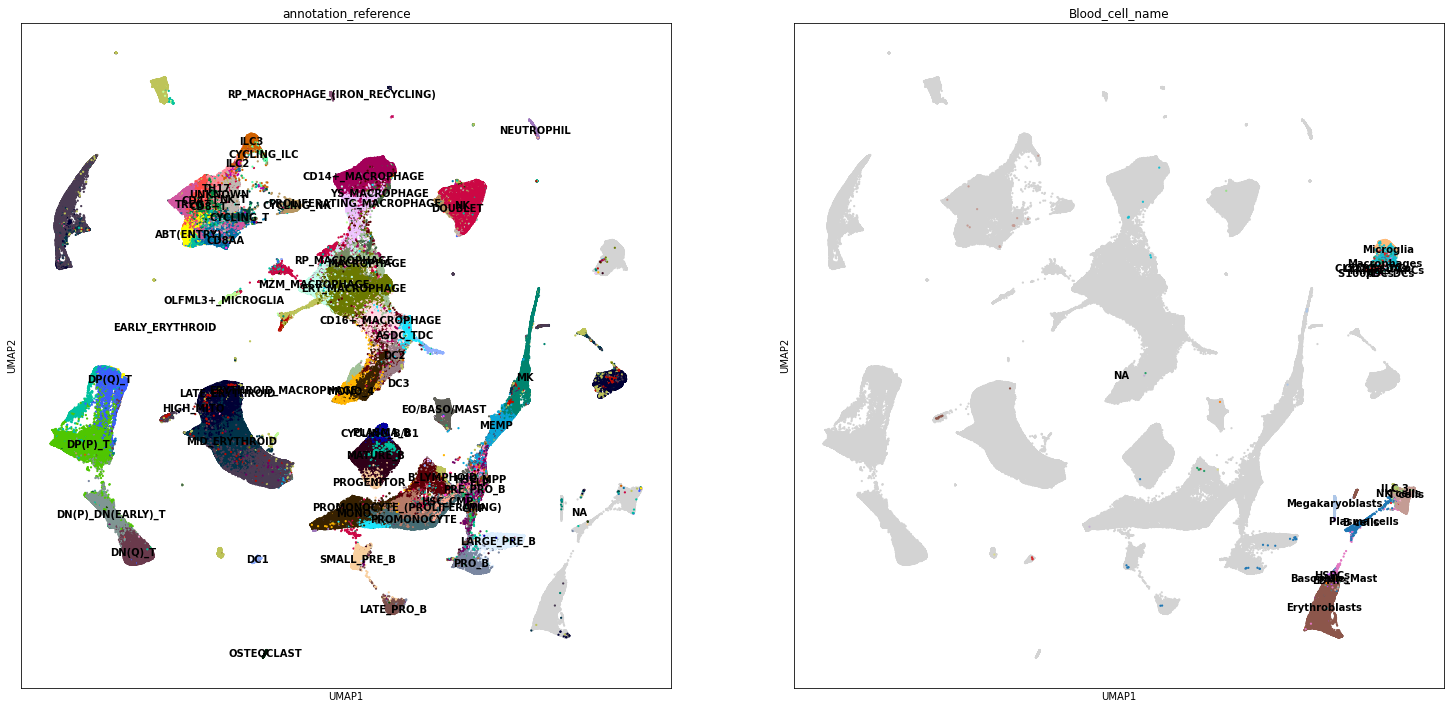

In [48]:

plt.rcParams["figure.figsize"] = [12,12]
sc.pl.umap(merged_adata, color=["annotation_reference","Blood_cell_name"], size=20, legend_loc="on data")

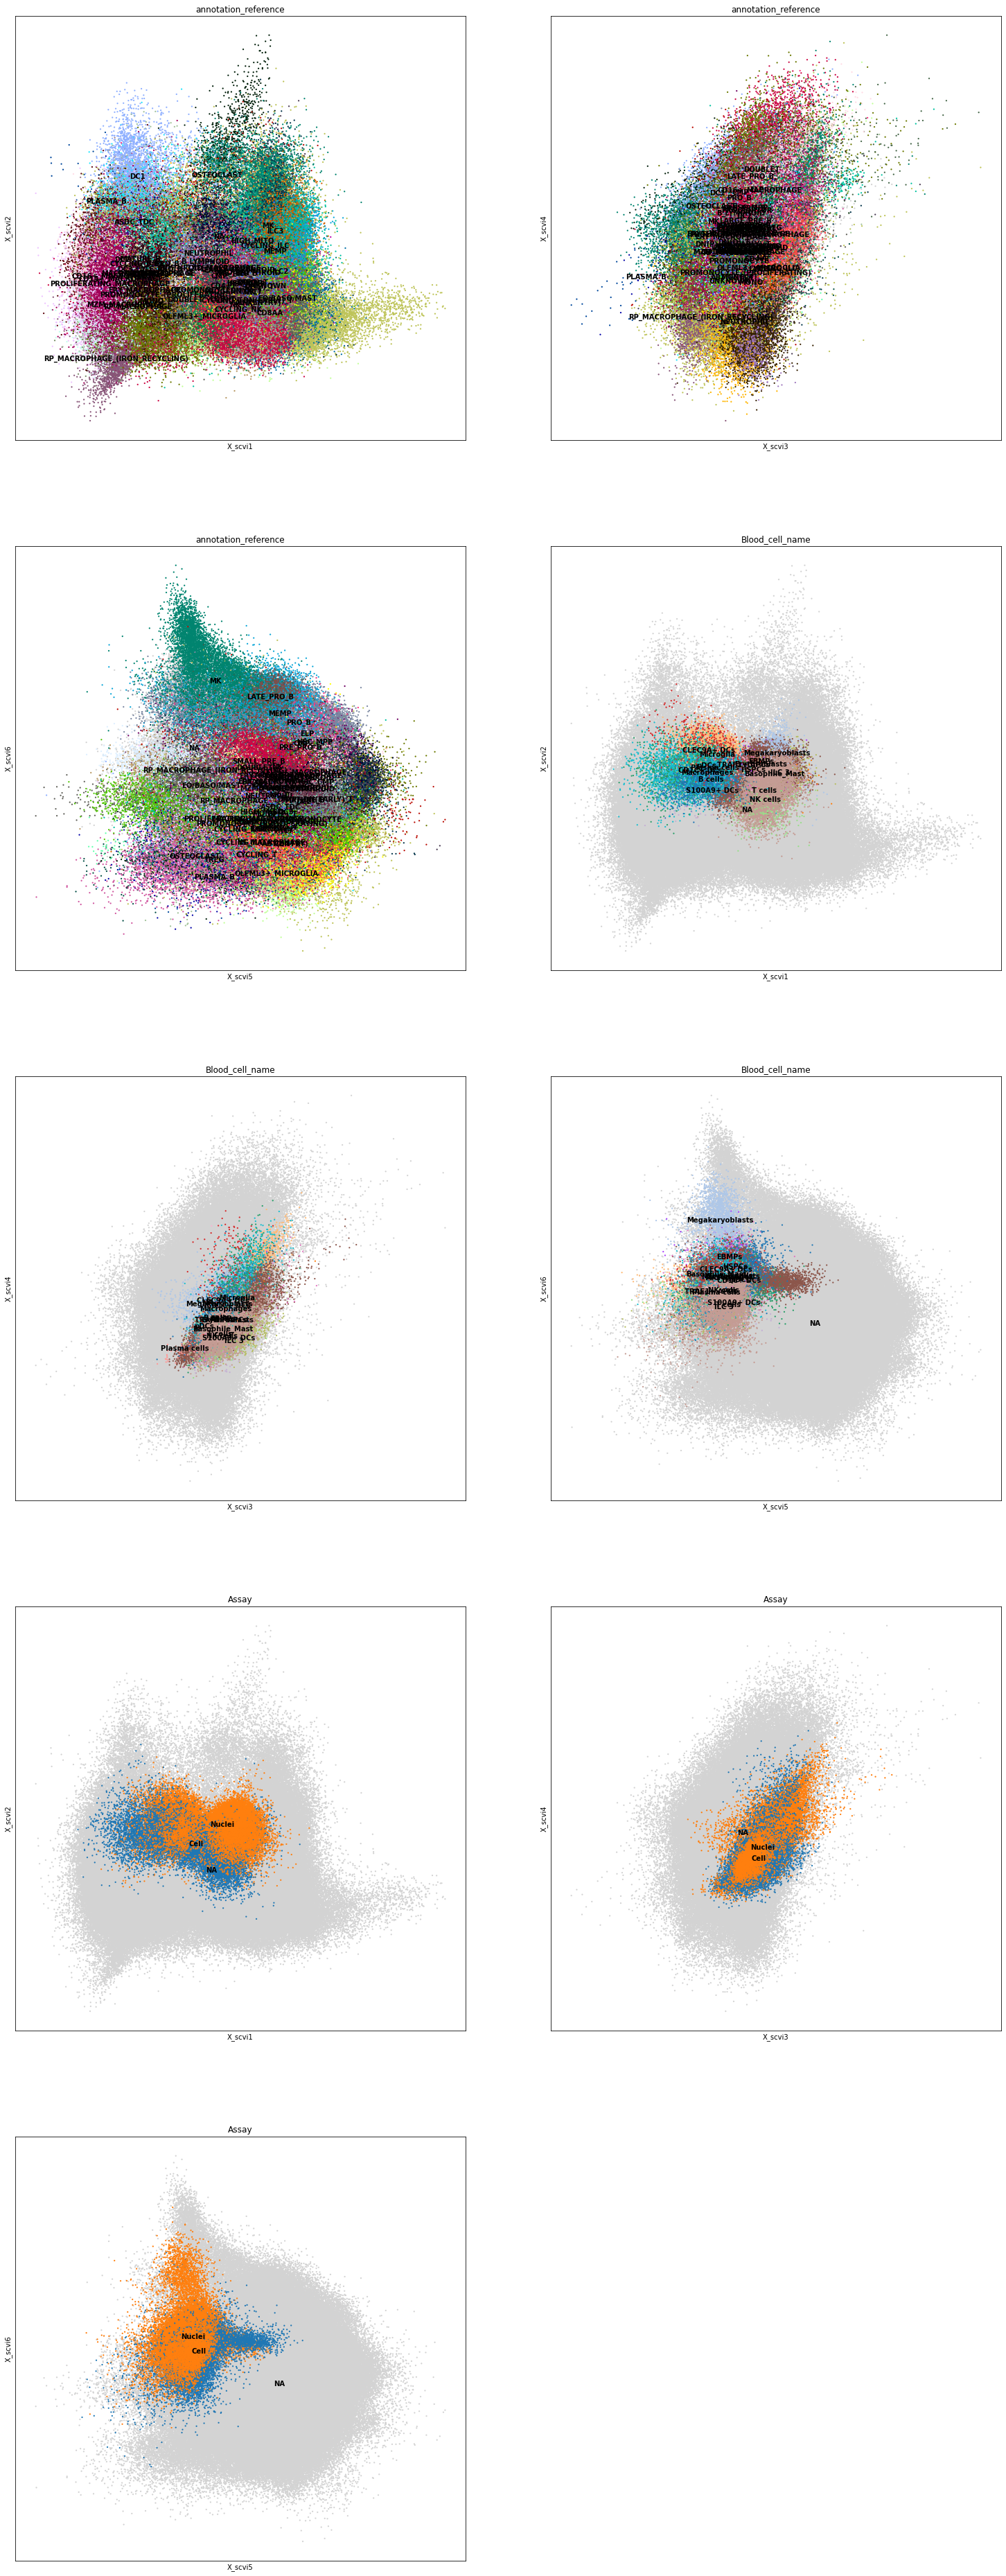

In [49]:
sc.pl.embedding(merged_adata,"X_scvi", color=["annotation_reference","Blood_cell_name", "Assay"], size=20, components=["1,2", "3,4", "5,6"], ncols=2, legend_loc="on data")

In [50]:
merged_adata.obs["All_reads"].min()

501.0

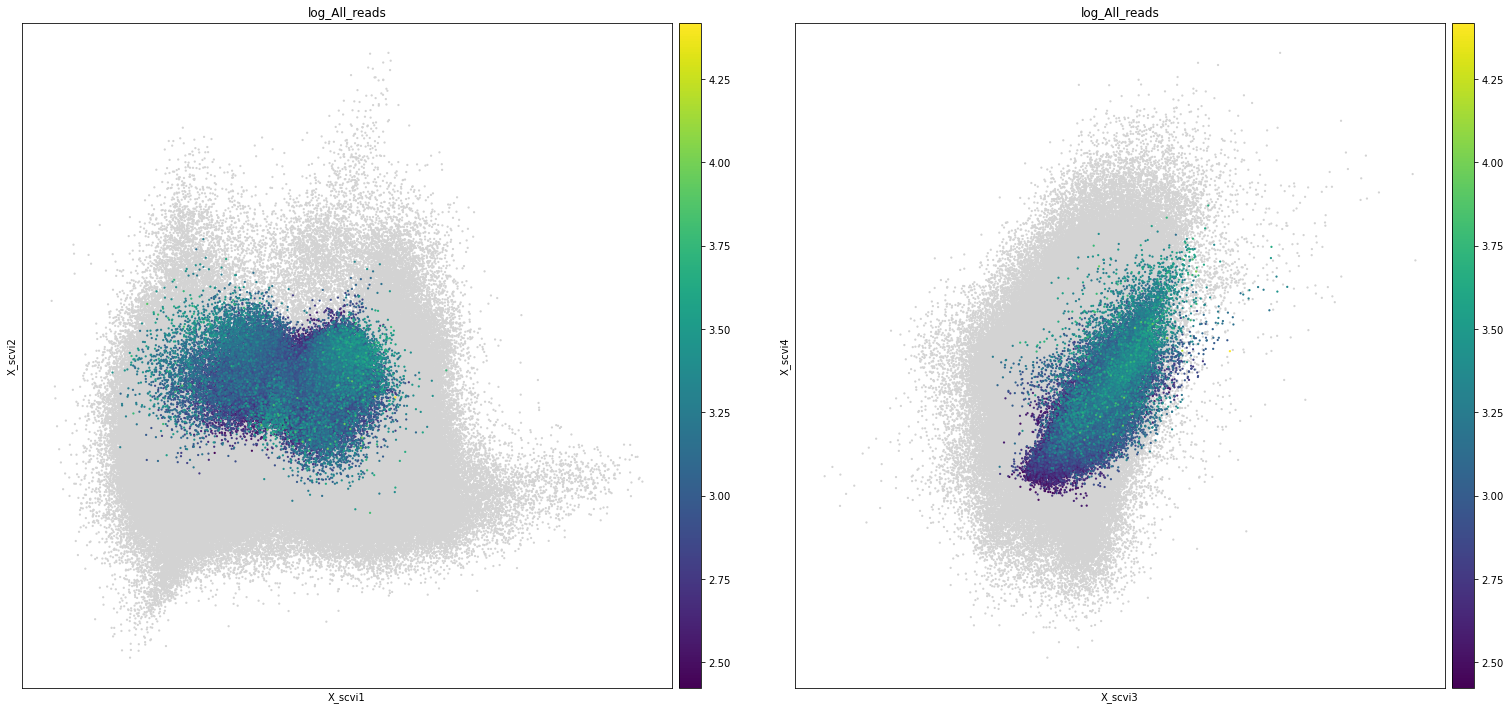

In [47]:
sc.pl.embedding(merged_adata,"X_scvi", color=["log_All_reads"], size=20, components=["1,2", "3,4"], ncols=2)

... storing 'has_predicted_anno' as categorical


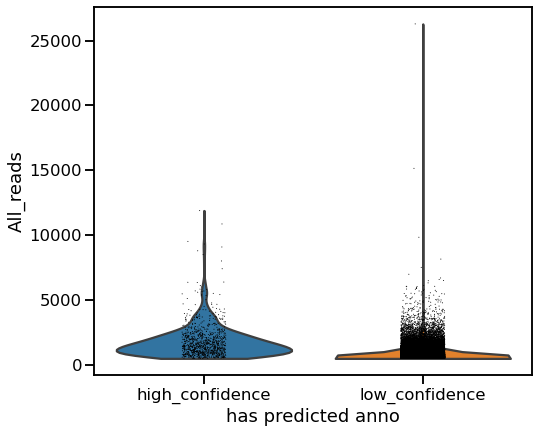

In [51]:
merged_adata.obs["has_predicted_anno"] = [x if x=="low_confidence" else "high_confidence" for x in merged_adata.obs["predicted_anno"]] 
plt.rcParams["figure.figsize"] = [7,7]
sns.set_context("talk")
sc.pl.violin(merged_adata, "All_reads", groupby="has_predicted_anno");

---

### Load data

In [9]:
cao_adata = sc.read_h5ad("/lustre/scratch117/cellgen/team205/ph12/201002_NewLung_DaweiRNA/210122ShendureFetalRaw.h5ad", backed="r")

## Save subsets for training 
- HSC/immune cells: for identification of finer subsets in Cao data
- Single organs: for validation of mapping approach and metrics, using both matched organs (LI, TH, SP) and organs that were not included in our reference. I expect that unmatched organs will have lower MNN/KNN ratio than matched organs.

In [37]:
## subset to HSC/Immune cells
hsc_immune_clusters = ["Myeloid cells", "Lymphoid cells", "Microglia", "Thymocytes", "Antigen presenting cells", "HSPCs", "Megakaryocytes", "Erythroblasts"]

is_immune = cao_adata.obs.Main_cluster_name.isin(hsc_immune_clusters)
immune_adata = cao_adata[is_immune]
immune_adata.obs["Organ"].value_counts()

immune_adata.copy("/nfs/team205/ed6/data/210122ShendureFetalRaw_HSC_immune.h5ad")

In [42]:
## Split and save by organs (for validation)
matched_organs = ["Liver", "Thymus", "Spleen"]
unmatched_organs = ["Lung", "Muscle", "Heart"]

for org in matched_organs + unmatched_organs:
    filename = "/nfs/team205/ed6/data/210122ShendureFetalRaw_{o}.h5ad".format(o=org)
    org_adata = cao_adata[cao_adata.obs.Organ == org]
    org_adata.copy(filename)

In [76]:
data_dir = '/nfs/team205/ed6/data/'
mapping_files = [x for x in os.listdir(data_dir) if x.startswith('210122ShendureFetalRaw_')]
## Prep for scArches
f=mapping_files[1]
# for f in mapping_files:

adata = sc.read_h5ad(data_dir + f)
## Convert var names to gene IDs
adata.var_names = [x[0] for x in adata.var["gene_id"].str.split(".")]
## Rename batch column
adata.obs["bbk"] = adata.obs["Batch"]
## Save in drive
adata.write_h5ad("/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/" + f.strip(".h5ad"))

In [52]:
var_names_model = pd.read_csv("/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/scvi_HSC_IMMUNE_model_test/" + "var_names.csv", header=None)[0].values

In [86]:
adata.X[0:100,0:2000].toarray().max()

504.53098

In [70]:
adata.var["gene_id_2"][adata.var["gene_id_2"].isin(var_names_model)]

gene_short_name
RP11-206L10.4     ENSG00000229905
RP11-54O7.3       ENSG00000223764
PLEKHN1           ENSG00000187583
HES4              ENSG00000188290
ISG15             ENSG00000187608
                       ...       
AC015849.16-1     ENSG00000270977
MRC1-1            ENSG00000260314
RP11-407P15.2     ENSG00000259916
CTD-2116F7.1-1    ENSG00000267719
WI2-2610K16.1     ENSG00000260220
Name: gene_id_2, Length: 7120, dtype: object

In [87]:
%%R
th_data = readRDS("/home/jovyan/Thymus_gene_count.RDS")

In [89]:
%%R
max(th_data)

[1] 142
